# Toy VQE Experiment using linear optical differentiation

We use the method of differentiating linear optics from https://arxiv.org/abs/2401.07997 to perform a toy **V**ariational **Q**uantum **E**igensolver experiment.

The purpose of VQE is to find the ground state $\ket{\psi(\theta)}$ of an observable $H$.

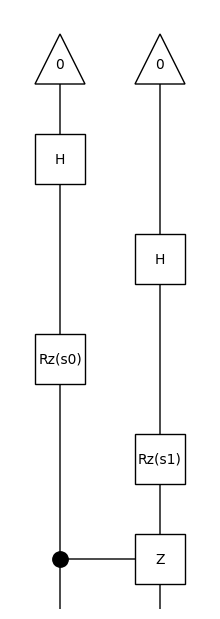

In [1]:
from discopy.quantum.circuit import Id
from discopy.quantum.gates import X, Ket, Bra, H, CRz, Rz
from sympy import Symbol

syms = [Symbol(f's{i}') for i in range(3)]
circ = Ket(0, 0).H(0).H(1).Rz(syms[0], 0).Rz(syms[1], 1).CZ(0, 1)

circ.draw()

Construct $E = \bra{\psi(-\theta)}H\ket{\psi(\theta)}$

$H = \frac{1}{2}[(Z + X)\otimes(Z + X)]$ is an Hermitian matrix.

The ground state is the state which minimises the expression $\bra{\psi(-\theta)}H\ket{\psi(\theta)}\$, known as the expectation of the observable.

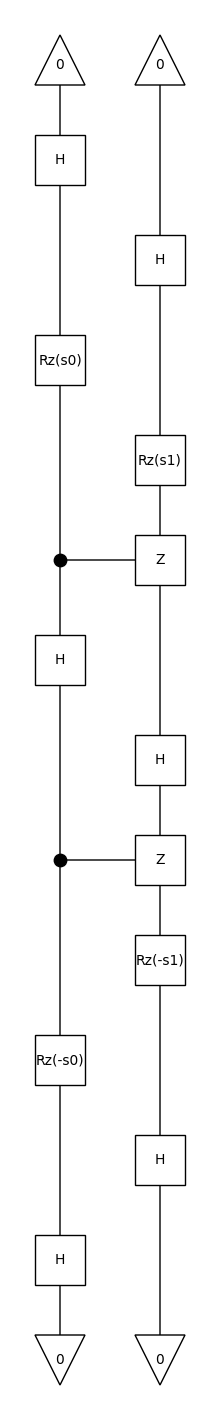

In [2]:
exp = circ >> Id().tensor(*[H] * len(circ.cod)) >> circ.dagger()
exp.draw()

In [3]:
from optyx.qubit import Circuit

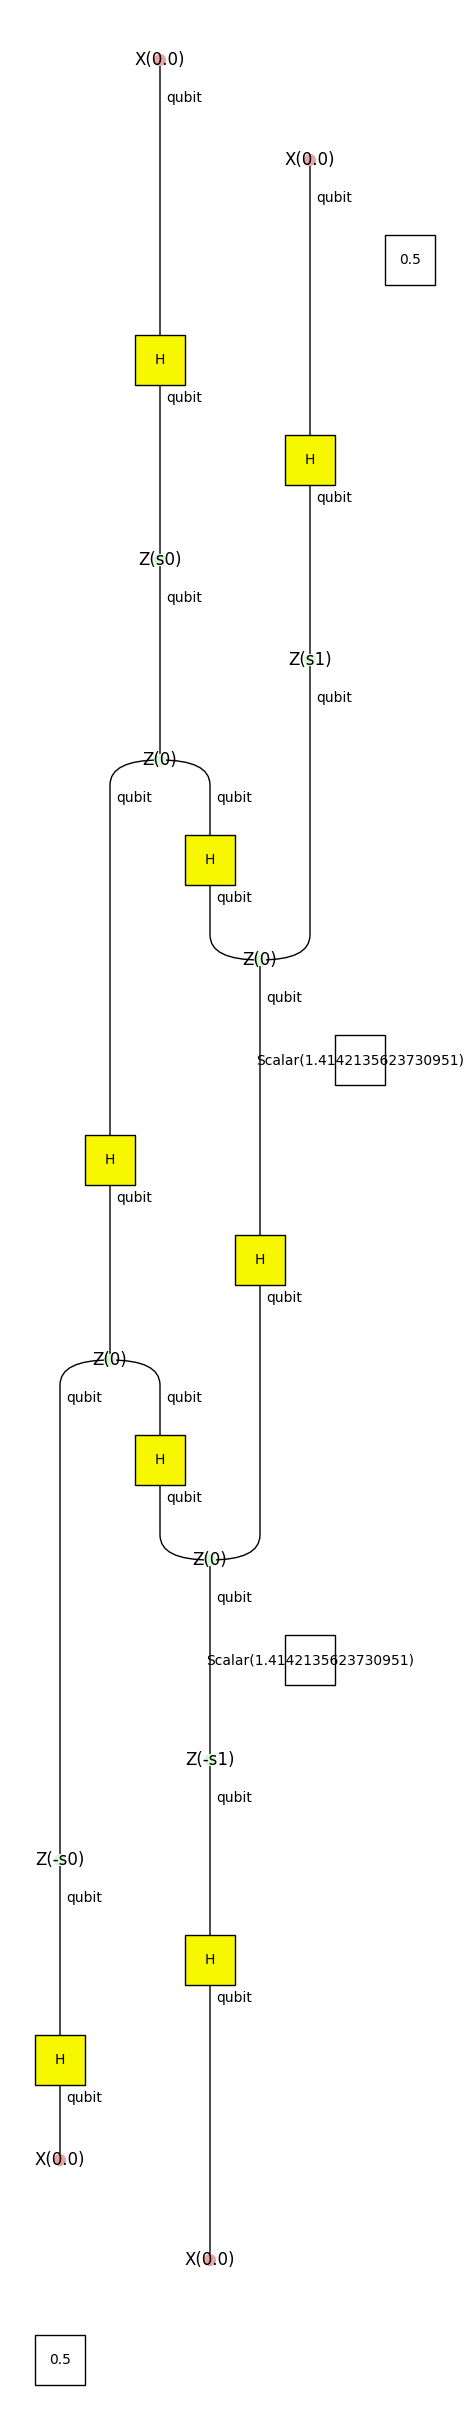

In [4]:
Circuit(exp)._to_optyx().draw()

In [7]:
def to_float(x):
    if isinstance(x, complex):
        assert x.imag < 1e-10
        return x.real
    return x

free_syms = exp.free_symbols

path_exp = Circuit(exp).to_dual_rail()
f_exp = lambda xs: to_float(path_exp.lambdify(*free_syms)(*xs).eval().array[0, 0])
orig_f_exp = lambda xs: to_float(exp.lambdify(*free_syms)(*xs).eval().array.item())

def d_f_exp(xs):
    return [
        path_exp.grad(s).lambdify(*free_syms)(*xs).eval().array[0, 0]
        for s in free_syms
    ]

NotImplementedError: Only ZX channels can be decomposed.

We use gradient descent to minimise the expectation.

In [5]:
from tqdm import tqdm

xs = []
fxs = []
dfxs = []

def optimize(x0):
    x = x0

    for _ in tqdm(range(20)):
        fx = f_exp(x)
        dfx = d_f_exp(x)
        orig_fx = orig_f_exp(x)

        # verifies that the conversion is correct
        assert abs(orig_fx - fx) < 1e-10

        xs.append(x[::])
        fxs.append(fx)
        dfxs.append(dfx)
        # print(x, fx, dfx)
        for i, dfxx in enumerate(dfx):
            x[i] = to_float(x[i] - 0.01 * dfxx)
    xs.append(x[::])
    fxs.append(f_exp(x))
    dfxs.append(d_f_exp(x))

In [6]:
optimize([0.1, 0.2])

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.36s/it]


<Axes: >

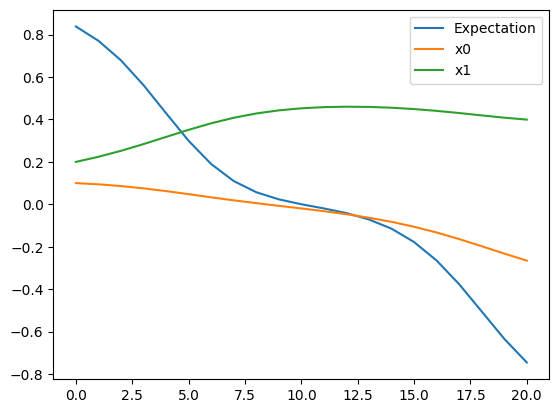

In [7]:
from pandas import DataFrame, Series

DataFrame({
    'Expectation': fxs,
    **{f'x{i}': [v[i] for v in xs] for i in range(len(free_syms))}
}).plot()